# Terminal commands for data access

```
ssh -AtX vschuma@ssh1.mdc-berlin.de ssh vschuma@murphy.mdc-berlin.net
# open the ssh screen and/or type
ssh -NR 6667:localhost:22 vfs@79.197.179.128 (current network ID)

# mount
sshfs -o follow_symlinks  -p 6667 vschuma@localhost:/data/local/rajewsky/home/vschuma /mnt/murphy_workspace/
or
sshfs -o follow_symlinks vschuma@murphy:/data/local/rajewsky/home/vschuma/ ~/mounts/murphy_workspace/

# if working with the mount is to slow, copy the data to a ramdisk
sudo mount -t tmpfs -o size=10g tmpfs /mnt/ramdisk/ && mkdir /mnt/ramdisk/data

# then copy the file to the ramdisk
rsync -av /mnt/murphy_workspace/NSTT/outputs/LabelTransfer/TNBC/*csv /mnt/ramdisk/data/
or
mkdir /dev/shm/data && rsync -av /home/vschuma/mounts/murphy_workspace/NSTT/data/GarciaAlsono_uterus/hot_data/* /dev/shm/data/
# symlink inside the pycharm project to the data dir
(example command)
ln -s /mnt/ramdisk/data data
e.g.: ln -s /mnt/murphy_workspace/NSTT/data/ data
or
ln -s /dev/shm/data/ data
```

In [3]:
%matplotlib inline
import anndata
import importlib.util
import sys
import novosparc
# spec = importlib.util.spec_from_file_location("novosparc",
#                                               "/data/local/rajewsky/home/vschuma/NSTT/novosparc/novosparc/__init__.py")
# novosparc = importlib.util.module_from_spec(spec)
# sys.modules["novosparc"] = novosparc
# spec.loader.exec_module(novosparc)
import os
import copy
import numpy as np
import pandas as pd
import scanpy as sc
import random
import squidpy as sq
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

'# Data

symlinked to `/data/local/rajewsky/home/vschuma/NSTT/outputs/LabelTransfer/TNBC`
## TNBC in-house atlas

In [ ]:
%%time
# atlas coordinates
#atlas_dir = 'output'
atlas_dir = 'data'
target_space_path = os.path.join(atlas_dir, 'TNBC_6w_fc51_4_coordinates.csv')
locations = pd.read_csv(target_space_path, sep=',')
num_locations = locations.shape[0] # coming from the spatial data #
locations_apriori = locations[:num_locations][['xcoord', 'ycoord']].values
locations = locations_apriori

# atlas data
atlas_path = os.path.join(atlas_dir, 'TNBC_reconstruction_atlas_MarkerGeneBased.csv')
chunks = pd.read_csv(atlas_path, index_col=0, chunksize=1000000)
df = pd.concat(chunks)
atlas = sc.AnnData(df)
atlas_genes = atlas.var.index.tolist()
print(len(atlas_genes))
print(atlas.shape)
print(locations.shape)
atlas.obsm['spatial'] = locations

# Subsample atlas
# n_loc = 100
# sc.pp.subsample(atlas, n_obs=n_loc)
locations = atlas.obsm['spatial']
locations_apriori = locations
atlas_genes = atlas.var.index.tolist()
print(len(atlas_genes))
print(atlas.shape)

## TNBC single-nuclei data

for preprocessing and information see `metadata_transfer_TNBC_sndata.ipynb`

In [4]:
%%time
# Reading expression data to scanpy AnnData (cells x genes)
# data_dir = 'output'
data_dir = 'data'

## read from file - deprecated if pickled zip is available
# data_path = os.path.join(data_dir, 'TNBC_sn_integrated_dge.csv')
# dataset = sc.read(data_path).T

## read from pickle archive
data_path = os.path.join(data_dir, 'TNBC_sn_integrated_dge.zip')
dataset_rdn = pd.read_pickle(data_path)
dataset = anndata.AnnData(dataset_rdn)
# normalize dataset
# sc.pp.normalize_per_cell(dataset)

gene_names = dataset.var.index.tolist()
num_cells, num_genes = dataset.shape
print('number of cells total: %d' % num_cells)
print('number of genes: %d' % num_genes)

# use only a subset for testing
# num_cells = 100
# print('number of cells used: %d' % num_cells)
# sc.pp.subsample(dataset, n_obs=num_cells)

CPU times: user 3.55 s, sys: 1.34 s, total: 4.89 s
Wall time: 11.8 s


<timed exec>:12: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Test Marker genes

In [ ]:
gene_table = os.path.join("data", '6week_all_markers.csv')
all_marker_genes = pd.read_csv(gene_table, sep=',')
marker_genes = all_marker_genes['gene'].tolist()
len(list(set(marker_genes) & set(atlas_genes)))

In [ ]:
# only some genes
# EDIT: 20032023 - no idea what this is
pl_genes = pd.DataFrame(atlas_genes).sample(500).values.flatten().tolist()
fixed_genes = ['Des','2310061N02Rik','Tnnt3','Krtap3-1','Krt14','Casq1','Igkc','Tmed3','Smox','Tkt','Arg1',
              'S100a4','Ltbp2','Flna','Krt33b','Plin1','Cfd','Chpt1','Ctnnb1','Actn4','Mylpf','Klk7','Sparc',
              'Chil1','Scd1']
novosparc.pl.embedding(atlas, pl_genes)

# Reconstruction
## create tissue object

In [ ]:
%%time
# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)

In [ ]:
%%time
# params for linear cost
markers = list(set(atlas_genes).intersection(gene_names))
# small subset for testing purposes
# markers = random.sample(markers,5)
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

### Reconstruct using atlas only, reduced marker set

In [ ]:
%%time
# using only linear cost to test if this is faster
# subsample markers to use
# tissue.setup_linear_cost(markers_to_use, atlas_matrix)

# compute optimal transport of cells to locations
# alpha_linear = 0.8
# epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
# tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

In [ ]:
print(type(tissue))
tissue.sdge

### Reconstruct using both assumptions, reduced marker set

In [ ]:
%%time
# alternative 1: setup both assumptions
# setup smooth
num_neighbors_s = num_neighbors_t = 5

tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)
tissue.setup_reconstruction(atlas_matrix=atlas_matrix,
                             markers_to_use=markers_to_use,
                             num_neighbors_s=num_neighbors_s,
                             num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 0.1
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

## save tissue object

**ToDo**
Try pickle object: https://pythonexamples.org/python-pickle-class-object/

In [ ]:
import pickle
save_dir = 'saved_objcs/'

In [ ]:
%%time

#create a pickle file
tissue_file = os.path.join(save_dir,"tissue_AllMarkerCellsLocations_MarkerBasedAtlas.pkl")
picklefile = open(tissue_file, 'wb')
#pickle the dictionary and write it to file
pickle.dump(tissue, picklefile)
#close the file
picklefile.close()

### unpickle the file

In [ ]:
#read the pickle file
picklefile = open(tissue_file, 'rb')
#unpickle the dataframe
tissue_pkled = pickle.load(picklefile)
#close file
picklefile.close()

#print the dataframe
print(type(tissue_pkled))

# Plotting
## Create tissue anndata

In [ ]:
type(tissue_pkled.sdge)

In [ ]:
# create
dataset_tissue = sc.AnnData(pd.DataFrame(tissue.sdge.T, columns = gene_names), dtype=float)
dataset_tissue.obsm['spatial'] = locations

# save\
dataset_tissue.write(os.path.join(save_dir, 'TNBC_tissue_sdge_basicRecon_MarkerBasedAtlas.h5ad'))

## Finding marker genes

### read in big marker gene list

In [ ]:
gene_table = os.path.join("data", '6week_all_markers.csv')
all_marker_genes = pd.read_csv(gene_table, sep=',')
marker_genes = all_marker_genes['gene'].tolist()
all_marker_genes

### find genes that are in all lists (atlas, data, marker)

In [ ]:
overlap_genes = list(set(atlas_genes) & set(marker_genes) & set(gene_names))
print(overlap_genes)

In [ ]:
print(len(gene_names))
print(len(marker_genes))
print(len(atlas_genes))

In [ ]:
for gene in overlap_genes:
 print(f"{gene} is a marker for: ","\n")
 print(all_marker_genes[all_marker_genes['gene'] == 'Cebpb']['cluster'])

### plot

In [ ]:
pl_genes = ['Des','S100a4','Mylpf', '2310061N02Rik', 'Krtap3-1','Plin1','Ltbp2','Cfd','Sparc','Igkc','Klk7','Chil1']
pl_genes_red 


novosparc.pl.embedding(atlas, pl_genes)
novosparc.pl.embedding(dataset_tissue, pl_genes)

## Search for more genes to display  

In [ ]:
overlap_genes2 = list(set(atlas_genes) & set(gene_names))
print(overlap_genes2)

In [ ]:
overlap3 = list(set(marker_genes) & set(gene_names)) 
print(overlap3)
len(list(set(overlap_genes2) & set(overlap3)))

In [ ]:
def make_lower(gene_list): 
    lower_list = [x.lower() for x in gene_list]  
    return lower_list

atlas_lower = make_lower(atlas_genes)
genes_lower = make_lower(gene_names)  
maker_lower = make_lower(marker_genes)

len(list(set(atlas_lower) & set(genes_lower) & set(maker_lower)))

In [ ]:
list(set(overlap_genes2) & set(marker_genes))

In [ ]:
pl_genes = list(set(marker_genes) & set(gene_names))

In [ ]:
novosparc.pl.embedding(atlas, pl_genes)
# novosparc.pl.embedding(dataset_tissue, pl_genes)

In [ ]:
len(tissue.sdge)

# Metadata
## meta data

In [ ]:
meta_data_dir = 'data'
# ToDo: Here could be a loop that fetches all available metadata files and merges them, or write it as a function which takes a dir of meta-data files or multiple files as input
meta_ct_path = os.path.join(meta_data_dir, "TNBC_meta_phase.csv")

phase_raw = pd.read_csv(meta_ct_path)
phase = np.asarray(phase_raw)

## gw from tissue

In [ ]:
## prepare gw matrix
gw_matrix = pd.DataFrame(tissue.gw)
type(gw_matrix)
print(gw_matrix.shape[0])

# save  
gw_matrix.to_csv('saved_objcs/gw_matrix_MarkerBasedAtlas.csv')

## merge metadata + gw

In [ ]:
print(phase_raw.shape)
print(gw_matrix.shape)

In [ ]:
p_gw_merge = gw_matrix.join(phase_raw)
print(p_gw_merge.shape)
print(p_gw_merge[:3])

In [24]:
type(tissue_pkled.sdge)

NoneType

In [67]:
# create
dataset_tissue = sc.AnnData(pd.DataFrame(tissue.sdge.T, columns = gene_names), dtype=float)
dataset_tissue.obsm['spatial'] = locations

# save\
dataset_tissue.write(os.path.join(save_dir, 'TNBC_tissue_sdge_basicRecon_MarkerBasedAtlas.h5ad'))

/data/local/rajewsky/home/vschuma/miniconda3/envs/novosparc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Finding marker genes

### read in big marker gene list

In [2]:
gene_table = os.path.join("data", '6week_all_markers.csv')
all_marker_genes = pd.read_csv(gene_table, sep=',')
marker_genes = all_marker_genes['gene'].tolist()
all_marker_genes

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,cell_type,compartment
0,1.001351e-126,0.183331,0.289,0.158,3.473486e-122,low_UMI,Clec3b,NaN,NaN
1,1.346538e-113,0.167937,0.346,0.205,4.670869e-109,low_UMI,Igfbp6,NaN,NaN
2,4.712664e-35,0.089403,0.240,0.171,1.634729e-30,low_UMI,Dpt,NaN,NaN
3,8.571468e-29,0.074106,0.175,0.121,2.973271e-24,low_UMI,Penk,NaN,NaN
4,2.257903e-28,0.062678,0.162,0.110,7.832213e-24,low_UMI,Pi16,NaN,NaN
...,...,...,...,...,...,...,...,...,...
24035,3.783217e-176,0.031251,0.523,0.244,1.312322e-171,low_UMI,Csn1s1,NaN,NaN
24036,3.374173e-112,0.052781,0.504,0.277,1.170433e-107,low_UMI,Csn3,NaN,NaN
24037,1.022758e-80,0.068989,0.108,0.033,3.547744e-76,low_UMI,Wap,NaN,NaN
24038,4.730852e-35,0.038639,0.122,0.059,1.641038e-30,low_UMI,Lalba,NaN,NaN


### find genes that are in all lists (atlas, data, marker)

592

In [11]:
overlap_genes = list(set(atlas_genes) & set(marker_genes) & set(gene_names))
print(overlap_genes)

['Neb', 'Rps29', 'Cebpb']


In [74]:
print(len(gene_names))
print(len(marker_genes))
print(len(atlas_genes))

3000
24040
600


In [47]:
for gene in overlap_genes:
 print(f"{gene} is a marker for: ","\n")
 print(all_marker_genes[all_marker_genes['gene'] == 'Cebpb']['cluster'])

Neb is a marker for:  

747      Tumor_luminal_1
4339       Tumor_Basal_1
6345          CAF_lowTnc
7287       Tumor_Basal_2
10328       Wap_positive
13117      Keratin_perls
16532       Normal_ducts
18835    Hormone_sensing
21446       CAFs_highTnc
22745    Tumor_luminal_2
Name: cluster, dtype: object
Cebpb is a marker for:  

747      Tumor_luminal_1
4339       Tumor_Basal_1
6345          CAF_lowTnc
7287       Tumor_Basal_2
10328       Wap_positive
13117      Keratin_perls
16532       Normal_ducts
18835    Hormone_sensing
21446       CAFs_highTnc
22745    Tumor_luminal_2
Name: cluster, dtype: object
Rps29 is a marker for:  

747      Tumor_luminal_1
4339       Tumor_Basal_1
6345          CAF_lowTnc
7287       Tumor_Basal_2
10328       Wap_positive
13117      Keratin_perls
16532       Normal_ducts
18835    Hormone_sensing
21446       CAFs_highTnc
22745    Tumor_luminal_2
Name: cluster, dtype: object


### plot

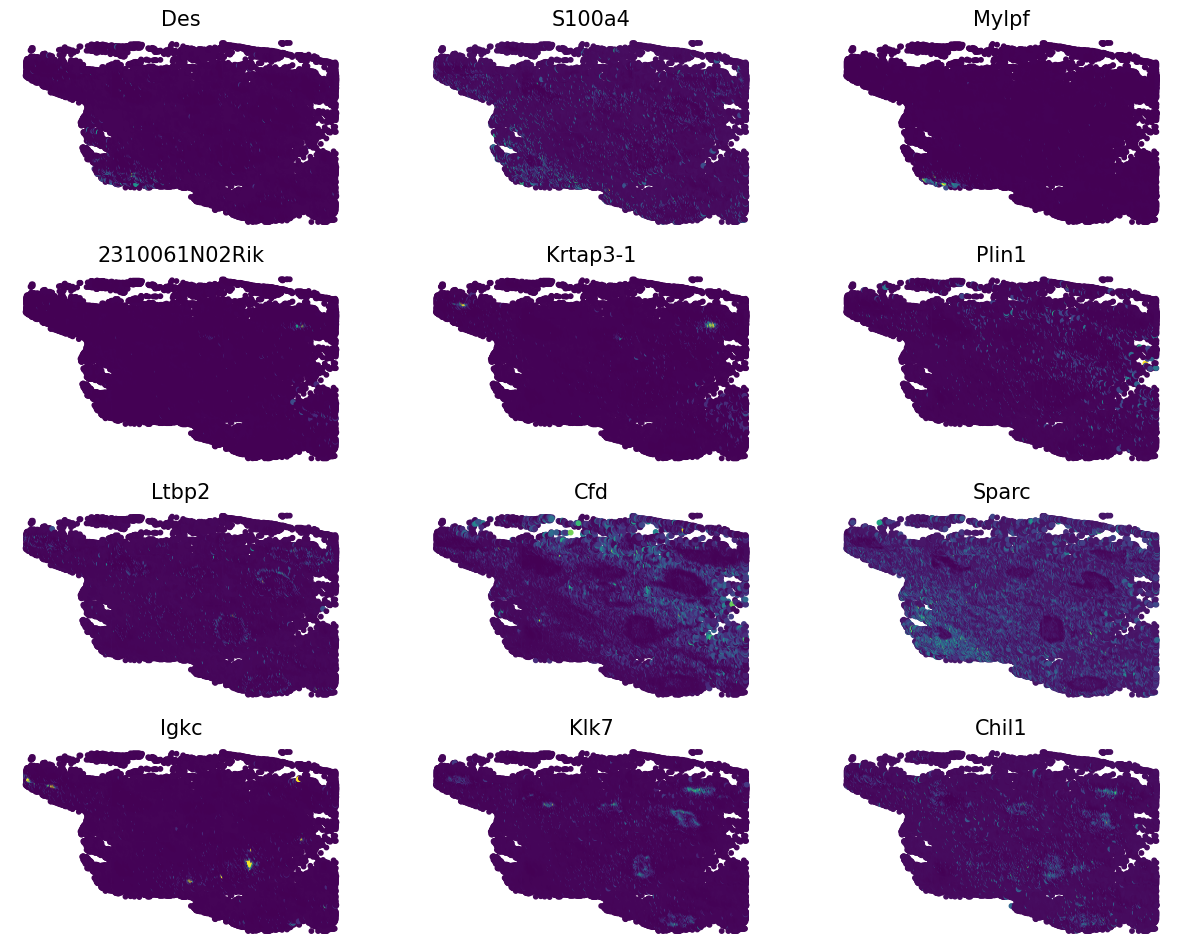

<Figure size 432x288 with 0 Axes>

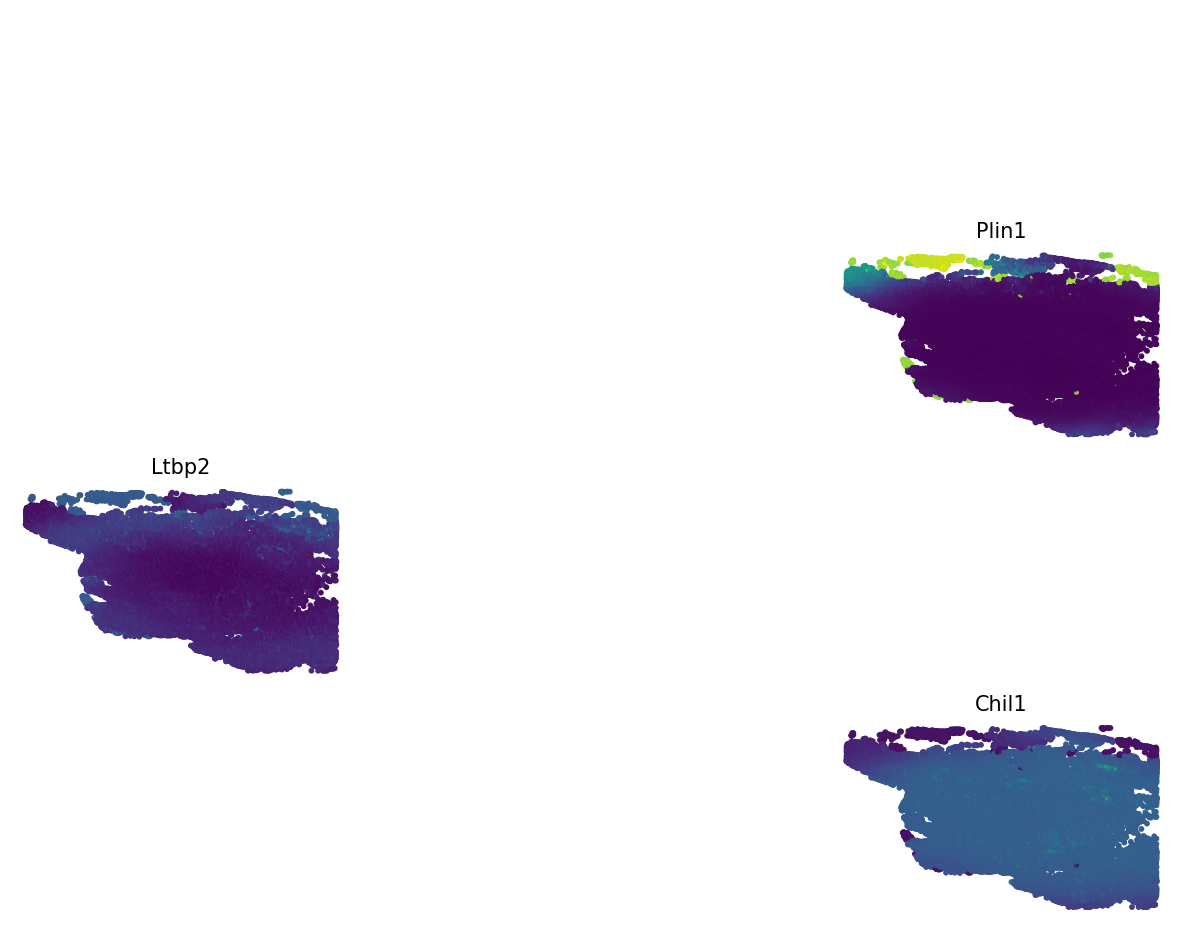

<Figure size 432x288 with 0 Axes>

In [69]:
pl_genes = ['Des','S100a4','Mylpf', '2310061N02Rik', 'Krtap3-1','Plin1','Ltbp2','Cfd','Sparc','Igkc','Klk7','Chil1']
pl_genes_red 


novosparc.pl.embedding(atlas, pl_genes)
novosparc.pl.embedding(dataset_tissue, pl_genes)

## Search for more genes to display  

In [20]:
overlap_genes2 = list(set(atlas_genes) & set(gene_names))
print(overlap_genes2)

['Cpa6', 'Cd8a', 'Nlgn1', 'Kcnab1', 'A630023A22Rik', 'Catsperd', 'Tfec', 'Mkx', 'Alox8', 'Cd200r1', 'Dgkb', 'Rgs1', 'Sv2b', 'Gcsam', 'Gm13546', 'Pthlh', 'Ccr9', 'Trpc6', 'Trdc', 'Lrrc7', 'Fut9', 'Cd69', 'F7', 'Lingo2', 'Ipcef1', 'Lmntd1', 'Kcnj16', 'Hepacam2', 'Has1', 'Cysltr2', 'Xkr6', 'Cd5', 'Klre1', 'Mgam', 'Tmem150c', 'Ubash3a', 'Gbp5', 'Bean1', 'Susd4', 'Pcdh17', 'Hs3st3a1', 'Cap2', 'Trim71', 'Chrdl1', 'Wnk2', 'Mreg', 'Havcr1', 'Cebpb', 'Cemip', 'Kcnk13', 'Fpr3', 'Hormad1', 'Hsd17b2', 'P2ry14', 'Cd38', 'Lhx6', 'Sorcs2', 'Rcan2', 'Cntfr', 'Rps29', 'Zfp831', 'Cyp4f18', 'Ccser1', 'Vrk2', 'Adamts16', 'Fgg', 'Mmd2', 'Ppm1e', '1700020G17Rik', 'Fgf7', 'Luzp2', 'Aspm', 'Egfl6', 'St8sia1', 'Cd79b', 'Wnt3', 'Adcy2', 'Foxp3', 'Lvrn', 'Klra7', 'Fam180a', 'Capn8', '4933406I18Rik', 'Tnfsf15', 'H2-Oa', 'Colq', 'Dnah8', 'Itgbl1', 'Fosb', 'Mirt1', 'Slamf6', 'Cdh19', 'Edil3', 'Hoxb9', 'Gm12253', 'Kcna6', 'Lrrc3b', 'Frmpd1', 'Xcr1', 'Klrc1', 'Efhc2', 'Klra17', 'Gm13710', 'Neb', 'Duox2', 'Nlgn3', 'Fr

In [19]:
overlap3 = list(set(marker_genes) & set(gene_names)) 
print(overlap3)
len(list(set(overlap_genes2) & set(overlap3)))

['Nhsl1', 'Col4a2', 'S100a7a', 'Lgr6', 'Tfap2a', 'Hspa1b', 'Gabrp', 'Pbx1', 'Lpl', 'Arsb', 'Cxcl16', 'Pla1a', 'Ptpn14', 'Esrp1', '0610040J01Rik', 'Ccl2', 'Dclk1', 'Pak1', 'Ifitm1', 'Pck1', 'Clec10a', 'Errfi1', 'Foxp1', 'Car3', 'Loxl1', 'Krt23', 'Col18a1', 'Cybrd1', 'Gpd1', 'Cfh', 'Abca1', 'Ednrb', 'Lipe', 'Sik1', 'H2-Aa', 'Stk39', 'Lamc2', 'Tspan8', 'Gbe1', 'Casz1', 'C3', 'Ptprc', 'Mboat2', 'Actn1', 'Synpo2', 'Hp', 'Wnt5b', 'Rin2', 'Ccl6', 'Sdc1', 'Pros1', 'Prrx1', 'C1qc', 'Lima1', 'Fnbp1l', 'Ctsl', 'Clec3b', 'Slit2', 'Sirpa', 'Krt36', 'Mt1', 'Myh11', 'Col3a1', 'Clec4n', 'Plbd1', 'Il33', 'Gng12', 'Hal', 'Adamts15', 'Epb41l4b', 'Col4a1', 'Rbpms', 'Fcrls', 'Eng', 'Nrp2', 'Map7', 'Lef1', 'Cdh5', 'Ccl9', 'Ppp3ca', 'Piezo2', 'Chka', 'Cilp', 'Sparcl1', 'Celf2', 'Palmd', 'Apobec1', 'Sox18', 'Svep1', 'Ccr5', 'Emilin2', 'Cped1', 'Sorbs2', 'Mrpl34', 'Egfr', 'Actb', 'Ctps', 'Rnf19b', 'Asprv1', 'Enpp2', 'Nedd4', 'Barx2', 'Nnat', 'Slc5a8', 'Plin4', 'Nxn', 'Tns3', 'Mybpc1', 'Jchain', 'Ltbp2', 'S100a

3

In [25]:
def make_lower(gene_list): 
    lower_list = [x.lower() for x in gene_list]  
    return lower_list

atlas_lower = make_lower(atlas_genes)
genes_lower = make_lower(gene_names)  
maker_lower = make_lower(marker_genes)

len(list(set(atlas_lower) & set(genes_lower) & set(maker_lower)))

3

In [80]:
list(set(overlap_genes2) & set(marker_genes))

['Neb', 'Cebpb', 'Rps29']

In [28]:
pl_genes = list(set(marker_genes) & set(gene_names))

In [29]:
novosparc.pl.embedding(atlas, pl_genes)
# novosparc.pl.embedding(dataset_tissue, pl_genes)

<Figure size 432x288 with 0 Axes>

In [76]:
len(tissue.sdge)

3000

# Metadata
## meta data

In [49]:
meta_data_dir = 'data'
# ToDo: Here could be a loop that fetches all available metadata files and merges them, or write it as a function which takes a dir of meta-data files or multiple files as input
meta_ct_path = os.path.join(meta_data_dir, "TNBC_meta_phase.csv")

phase_raw = pd.read_csv(meta_ct_path)
phase = np.asarray(phase_raw)

## gw from tissue

In [68]:
## prepare gw matrix
gw_matrix = pd.DataFrame(tissue.gw)
type(gw_matrix)
print(gw_matrix.shape[0])

# save  
gw_matrix.to_csv('saved_objcs/gw_matrix_MarkerBasedAtlas.csv')

26978


## merge metadata + gw

In [51]:
print(phase_raw.shape)
print(gw_matrix.shape)

(26978, 1)
(26978, 55478)


In [52]:
p_gw_merge = gw_matrix.join(phase_raw)
print(p_gw_merge.shape)
print(p_gw_merge[:3])

(26978, 55479)
              0             1             2             3             4  \
0  1.329798e-09  1.320845e-09  1.642880e-09  1.318630e-09  1.305234e-09   
1  2.102975e-10  2.208429e-10  1.862287e-10  2.224042e-10  2.281853e-10   
2  1.646482e-10  1.546638e-10  2.102034e-10  1.529018e-10  1.458644e-10   

              5             6             7             8             9  ...  \
0  1.321460e-09  1.330904e-09  1.560559e-09  1.277799e-09  1.338026e-09  ...   
1  2.021754e-10  2.144516e-10  2.087271e-10  2.333042e-10  2.063618e-10  ...   
2  1.668072e-10  1.615554e-10  1.705122e-10  1.324614e-10  1.692453e-10  ...   

          55469         55470         55471         55472         55473  \
0  1.948486e-14  1.947594e-14  1.949705e-14  1.948558e-14  1.949427e-14   
1  1.646615e-21  1.632233e-21  1.645034e-21  1.628561e-21  1.645410e-21   
2  3.115228e-08  3.077041e-08  3.119565e-08  3.073891e-08  3.118462e-08   

          55474         55475         55476         55477  Pha

In [ ]:
overlap_genes = list(set(atlas_genes) & set(gene_names))

novosparc.pl.embedding(atlas, overlap_genes)